In [21]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
pd.set_option('display.max_columns', 500)

In [6]:
#Calculates the mean values of Fss, Fsv, and Fvv across all rows of their 96 columns

train['Fss_mean'] = train.iloc[:, 4:100].apply(np.mean, axis = 1)
train['Fsv_mean'] = train.iloc[:, 100:196].apply(np.mean, axis = 1)
train['Fvv_mean'] = train.iloc[:, 196:292].apply(np.mean, axis = 1)

test['Fss_mean'] = test.iloc[:, 3:99].apply(np.mean, axis = 1)
test['Fsv_mean'] = test.iloc[:, 99:195].apply(np.mean, axis = 1)
test['Fvv_mean'] = test.iloc[:, 195:291].apply(np.mean, axis = 1)

In [7]:
#Drops the Fss, Fsv, and Fvv columns that were used to calculate the mean values in the block above

train = train.drop(train.iloc[:, 4:292], axis = 1)
test = test.drop(test.iloc[:, 3:291], axis = 1)

In [43]:
#Assigns our predictor and target variables from our training dataset

X = train[['phi', 's', 'tau', 'Fss_mean', 'Fsv_mean', 'Fvv_mean']]
y = train['permeability']

In [15]:
#Our train_test_split statement dividing up the data and establishing variable names for analysis

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 8669, test_size=0.25
)

In [16]:
#Applies the column transformer to the 3 variables that were greatly skewed

ct = ColumnTransformer(transformers = [
    ('yeo-johnson', PowerTransformer(), ['s', 'Fss_mean', 'Fsv_mean']),
    ('poly', PolynomialFeatures(degree = 2, include_bias = False), ['s', 'Fss_mean', 'Fsv_mean'])
], remainder = 'passthrough')

#Creates a pipeline

pipe = Pipeline(steps = [
    ('transform', ct),
    ('linear', LinearRegression())
])

In [17]:
#Applies the...I don't really understand what this does yet, it looks like it applies a log function across everything

ttr = TransformedTargetRegressor(regressor = pipe, func = np.log, inverse_func = np.exp)

In [18]:
#Creates the model using our training subset

ttr.fit(X_train, y_train);

In [19]:
np.sqrt(mean_squared_error(y_test, ttr.predict(X_test)))

1.1521360655937205

In [22]:
mean_absolute_error(y_test, ttr.predict(X_test))

0.38379826291154245

In [31]:
#Assigns a variable we can use to get a .score()

linreg_test1 = ttr.fit(X_train, y_train)

In [32]:
linreg_test1.score(X_test, y_test)

0.9825086778310254

In [33]:
#Assigns a variable to the .fit() --that we used earlier-- and .predict() so we can see our model graphed and later apply
#it to our test.csv

linreg_test1_pred = ttr.fit(X_train, y_train).predict(X_test)

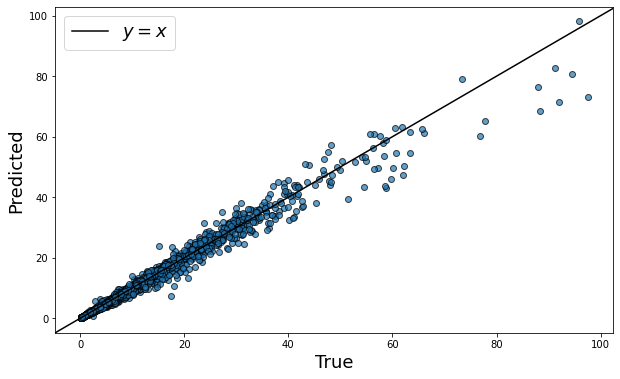

In [34]:
#Graph via Tim's notebook that shows our model and test data

plt.figure(figsize = (10,6))

plt.scatter(y_test, ttr.predict(X_test), alpha = 0.7, edgecolor = 'black')

fontsize = 18
plt.xlabel('True', fontsize = fontsize)
plt.ylabel('Predicted', fontsize = fontsize)

ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

start = min(xmin, ymin)
stop = max(xmax, ymax)
plt.plot([start, stop], [start, stop], color = 'black', label = '$y = x$')
plt.legend(fontsize = fontsize)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax);

In [27]:
#Creates an empty dataframe to store the predicted values

linreg_test1_results = pd.DataFrame()

In [28]:
#Saves predicted values into the df's permeability columns

#Notice that the .predict calls our test df and not our train df

#Out training data frame is used since it's called already by .fit(), the coefficiencts are then applied across the test df 
#because we called them here in the .predict()

#This has to be done since there is not an easy way to pull out the coefficients from the transformations within the column
#transformer since their yeo/log/poly etc

linreg_test1_results['permeability'] = linreg_test1.predict(test)

In [29]:
#Exports as a csv with a proper index lavel of id to match the samplesubmission format

linreg_test1_results.to_csv('data/linreg_test1_results.csv', index_label = 'id')